## Goals

- better understand the use of unsupervised learning techniques
- use a variety of methods and models
- explore hyperparamater tuning

## The Dataset

Here I will use the [FIFA2019 dataset](https://www.kaggle.com/karangadiya/fifa19) from Kaggle. I will import it from Thinkful's postgreSQL server.

### Import Libraries and Define Functions

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sqlalchemy import create_engine

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(df):
    out = pd.Series({'Column': 'Percentage of nulls', '-----' : '-----'}
                   ).append(df.isnull().sum()*100/df.isnull().isnull().count())
   
    return print_full(out)

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

### Load the dataset

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'fifa19'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
    
query1='''
SELECT
    *
FROM
    fifa19
'''
    
    
df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [5]:
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
# Make column names lowercase for ease and consistency
df.columns= df.columns.str.lower()

# Drop a few unnecessary columns
df.drop(['id', 'name', 'photo', 'flag', 'club logo', 'real face',
       'jersey number', 'joined', 'loaned from', 'contract valid until']
        , axis=1, inplace=True)

In [7]:
print_nulls(df)

Column                      Percentage of nulls
-----                                     -----
age                                           0
nationality                                   0
overall                                       0
potential                                     0
club                                    1.32367
value                                         0
wage                                          0
special                                       0
preferred foot                         0.263635
international reputation               0.263635
weak foot                              0.263635
skill moves                            0.263635
work rate                              0.263635
body type                              0.263635
position                               0.329544
height                                 0.263635
weight                                 0.263635
ls                                      11.4516
st                                      

### Splitting the data set by fielders and goal keepers

The consistent 11.5% null rate in the position scores is largely explained by the overlap with players are goal keepers. The rest of the nulls are a very small amount and those observations can be dropped. Rather than filling a large portion of the variables with 0 it makes more sense to divide the dataset this way and look for clusters in each. 

In [8]:
print_nulls(df[df['position'] != 'GK'])

Column                      Percentage of nulls
-----                                     -----
age                                           0
nationality                                   0
overall                                       0
potential                                     0
club                                    1.28538
value                                         0
wage                                          0
special                                       0
preferred foot                         0.296626
international reputation               0.296626
weak foot                              0.296626
skill moves                            0.296626
work rate                              0.296626
body type                              0.296626
position                               0.370782
height                                 0.296626
weight                                 0.296626
ls                                     0.370782
st                                     0

In [9]:
keepers = df[df['position'] == 'GK'].copy()

fielders = df[df['position'] != 'GK'].copy()

In [10]:
fielders[['gkdiving', 'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes']].describe()

,gkdiving,gkhandling,gkkicking,gkpositioning,gkreflexes
count,16134.000000,16134.000000,16134.000000,16134.000000,16134.000000
mean,10.502851,10.558262,10.553242,10.532726,10.511776
std,3.113639,3.087163,3.166154,3.100881,3.123893
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,8.000000,8.000000,8.000000,8.000000
50%,10.000000,11.000000,11.000000,11.000000,10.000000
75%,13.000000,13.000000,13.000000,13.000000,13.000000
max,53.000000,48.000000,62.000000,57.000000,60.000000


In [11]:
keepers[['gkdiving', 'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes']].describe()

,gkdiving,gkhandling,gkkicking,gkpositioning,gkreflexes
count,2025.000000,2025.000000,2025.000000,2025.000000,2025.000000
mean,65.323951,62.868148,61.477531,63.047407,66.101728
std,7.768497,7.486476,7.626315,8.671413,8.213524
min,45.000000,43.000000,35.000000,38.000000,44.000000
25%,60.000000,58.000000,56.000000,57.000000,60.000000
50%,65.000000,63.000000,61.000000,63.000000,66.000000
75%,70.000000,68.000000,66.000000,69.000000,72.000000
max,90.000000,92.000000,91.000000,90.000000,94.000000


In [12]:
keepers.drop(['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb'], axis=1, inplace=True)

In [13]:
# Define a function to apply derived functions for this dataset 

def clean(df):
    # Drop the small portion of remaining nulls
    df = df.dropna().copy() 
    
    # Values for wage and value need to be converted from strings to numerical 

    df['wage'] = df['wage'].apply(lambda x: int(str(x).replace('€', '').replace('K', '')
                                               ) * 1000 if 'K' in str(x) else x)

    df['wage'] = df['wage'].apply(lambda x: int(str(x).replace('€', '').replace('M', '')
                                               ) * 1000000 if 'M' in str(x) else x)

    df['wage'] = df['wage'].apply(lambda x: 0 if str(x) == '€0' else x)



    df['value'] = df['value'].apply(lambda x: float(str(x).replace('€', '').replace('K', '')
                                               ) * 1000 if 'K' in str(x) else x)

    df['value'] = df['value'].apply(lambda x: float(str(x).replace('€', '').replace('M', '')
                                               ) * 1000000 if 'M' in str(x) else x)

    df['value'] = df['value'].apply(lambda x: 0 if str(x) == '€0' else x)
    
    
    '''
    The release clause value presents a difficulty for filling. Presumably these are players that do 
    not have a release clause. As shown above this includes players at both the high and low end of the
    pay scale. Filling these nulls with 0 makes no sense and infinity is not supported by algorithms
    despite being logically closer. Perhaps turning this into a categorical variable would help?
    Luckily this is not a regression problem where the value would be more important.
    For now I will fill these values with 0 because all I am trying to achieve right now is clustering
    and this will give these observations a valid common value.
    '''
    
    df['release clause'] = df['release clause'].fillna(0)
    
    df['release clause'] = df['release clause'].apply(lambda x: float(str(x).replace('€', '').replace('K', '')
                                               ) * 1000 if 'K' in str(x) else x)

    df['release clause'] = df['release clause'].apply(lambda x: float(str(x).replace('€', '').replace('M', '')
                                               ) * 1000000 if 'M' in str(x) else x)

    df['release clause'] = df['release clause'].apply(lambda x: 0 if str(x) == '€0' else x)
    
    
    # Convert height to int
    df['height'] = df['height'].apply(lambda x : str(x).split('\''))

    df['height'] = df['height'].apply(lambda x : (int(x[0]) * 12) + int(x[1]))
    
    
    # Convert weight to int
    df['weight'] = df['weight'].apply(lambda x : int(str(x).strip('lbs')))
    
    
    # Encode perferred foot as numerical
    df['right preferred'] = df['preferred foot'].apply(lambda x : 1 if str(x) == 'Right'
                                                  else 0)
    df.drop('preferred foot', axis=1, inplace=True)
    
    
    # For the fielders their position scores need to be cleaned and typed properly
    for col in ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb']:
    
        if col in df.columns:

            df[col] = df[col].apply(lambda x: sum([int(i) for i in str(x).split('+')]))
        
    # Seperate and encode the workrate values as ordinal
    #df['defense work rate'] = df['work rate'].apply(lambda x: 3 if (str(x).split('/ '))[1] == 'High' else
    #                                          (2 if (str(x).split('/ '))[1] == 'Medium' else 1))

    #df['offense work rate'] = df['work rate'].apply(lambda x: 3 if (str(x).split('/ '))[0] == 'High' else
    #                                               (2 if (str(x).split('/ '))[0] == 'Medium' else 1))
    
    df.drop('work rate', axis=1, inplace=True)
    
    # Drop the categorical variables

    df.drop('position', axis=1, inplace=True)

    df.drop('body type', axis=1, inplace=True)

    df.drop('club', axis=1, inplace=True)

    df.drop('nationality', axis=1, inplace=True)

    return df

In [14]:
fielders = clean(fielders)

In [ ]:
keepers = clean(keepers)

In [ ]:
plot_hist_boxplot(fielders)

In [ ]:
plot_hist_boxplot(keepers)

In [15]:
fielders.drop('wage', axis=1, inplace=True)

fielders['value'] = np.log(fielders['value'])

In [16]:
scaler = StandardScaler()

In [17]:
X = scaler.fit_transform(fielders)

In [ ]:
umap_2d(X)

In [ ]:
# Define a function to print a 2D PCA

def pca_2d(df):
    # initalize the module and get the components
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(df)
    
    # plot the 2D representation
    fig = plt.figure(figsize=(12,12))
    plt.scatter(pca_components[:, 0], pca_components[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()
    
    return pca_components

In [ ]:
# Define a function to print a 3D PCA
from mpl_toolkits.mplot3d import Axes3D

def pca_3d(df):
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(df)
    
    # Plot the 3D representation
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    plt.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2])

In [ ]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(keepers)
    


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[:, 0], pca_components[:, 1], zs=pca_components[:, 2], zdir='z')

In [ ]:
fielders['value'].describe()

In [ ]:
log = np.log(fielders['value'])

plt.hist(log)

In [ ]:
scaler = StandardScaler()

plt.hist(scaler.fit_transform(np.log(fielders['value'].values.reshape(-1,1))))

In [ ]:
import scipy

In [ ]:
from scipy.stats import jarque_bera

In [ ]:
jarque_bera(np.log(fielders['value']))

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
pt = PowerTransformer()

In [ ]:
pt_fielders = pt.fit_transform(fielders)

In [18]:
# Define a function to print a UMAP

def umap_2d(df):
    umap_components = umap.UMAP(n_neighbors=10,
                      min_dist=.5,
                      metric='euclidean').fit_transform(df)

    
    # plot the 2D representation
    fig = plt.figure(figsize=(12,12))
    plt.scatter(umap_components[:, 0], umap_components[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()
    
    return umap_components

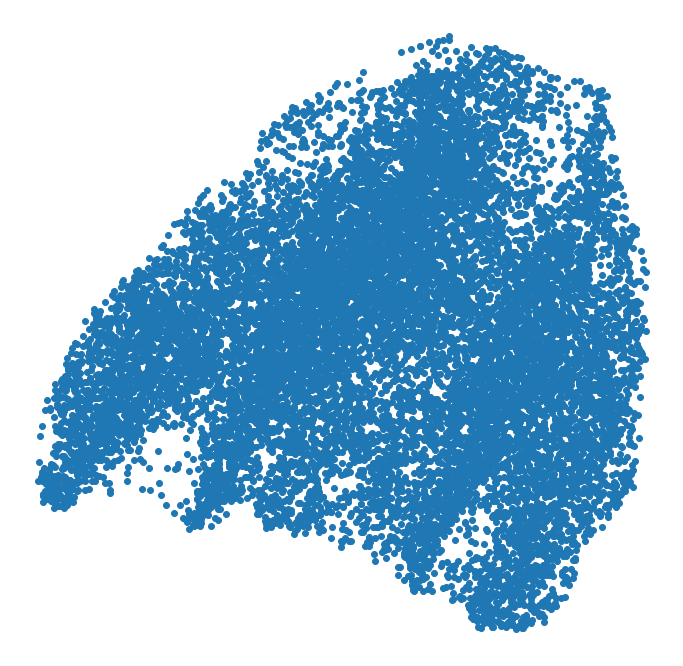

array([[11.903269  , 10.944121  ],
       [11.870218  , 10.524746  ],
       [11.853652  , 10.9182205 ],
       ...,
       [ 8.58415   , -2.4793937 ],
       [ 7.1403904 , -1.5786022 ],
       [ 3.1250641 ,  0.13088177]], dtype=float32)

In [19]:
umap_2d(X)

In [ ]:
pca_2d(fielders)

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(fielders)

## K-means
Assumptions
- K clusters in the data
- clusters are isotropic
- similar variance

Text(0, 0.5, 'Inertia')

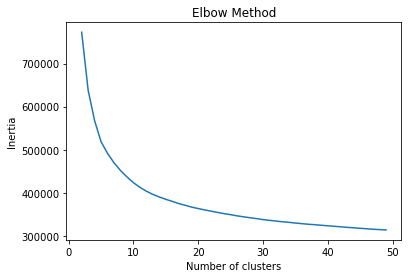

In [20]:


#Elbow Method
seed = 0
elbow = dict()
for k in range(2,50):
    estimator = KMeans(n_clusters = k,random_state=seed)
    res = estimator.fit_predict(X)
    inertia = estimator.inertia_
    elbow[k] = inertia
    
elbow_df = pd.Series(elbow)
ax = elbow_df.plot(title = 'Elbow Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
#plt.plot(3,elbow_df[3],'ro')

In [ ]:
estimator = KMeans(n_clusters = 3,random_state=1312)
res = estimator.fit_predict(X)


print(metrics.silhouette_score(X, res, metric='euclidean'))

## Hierarchical
Assumptions and Considerations
- Linkage Method tuned to cluster shapes/composition


In [21]:
linkages = ['complete', 'average', 'ward']

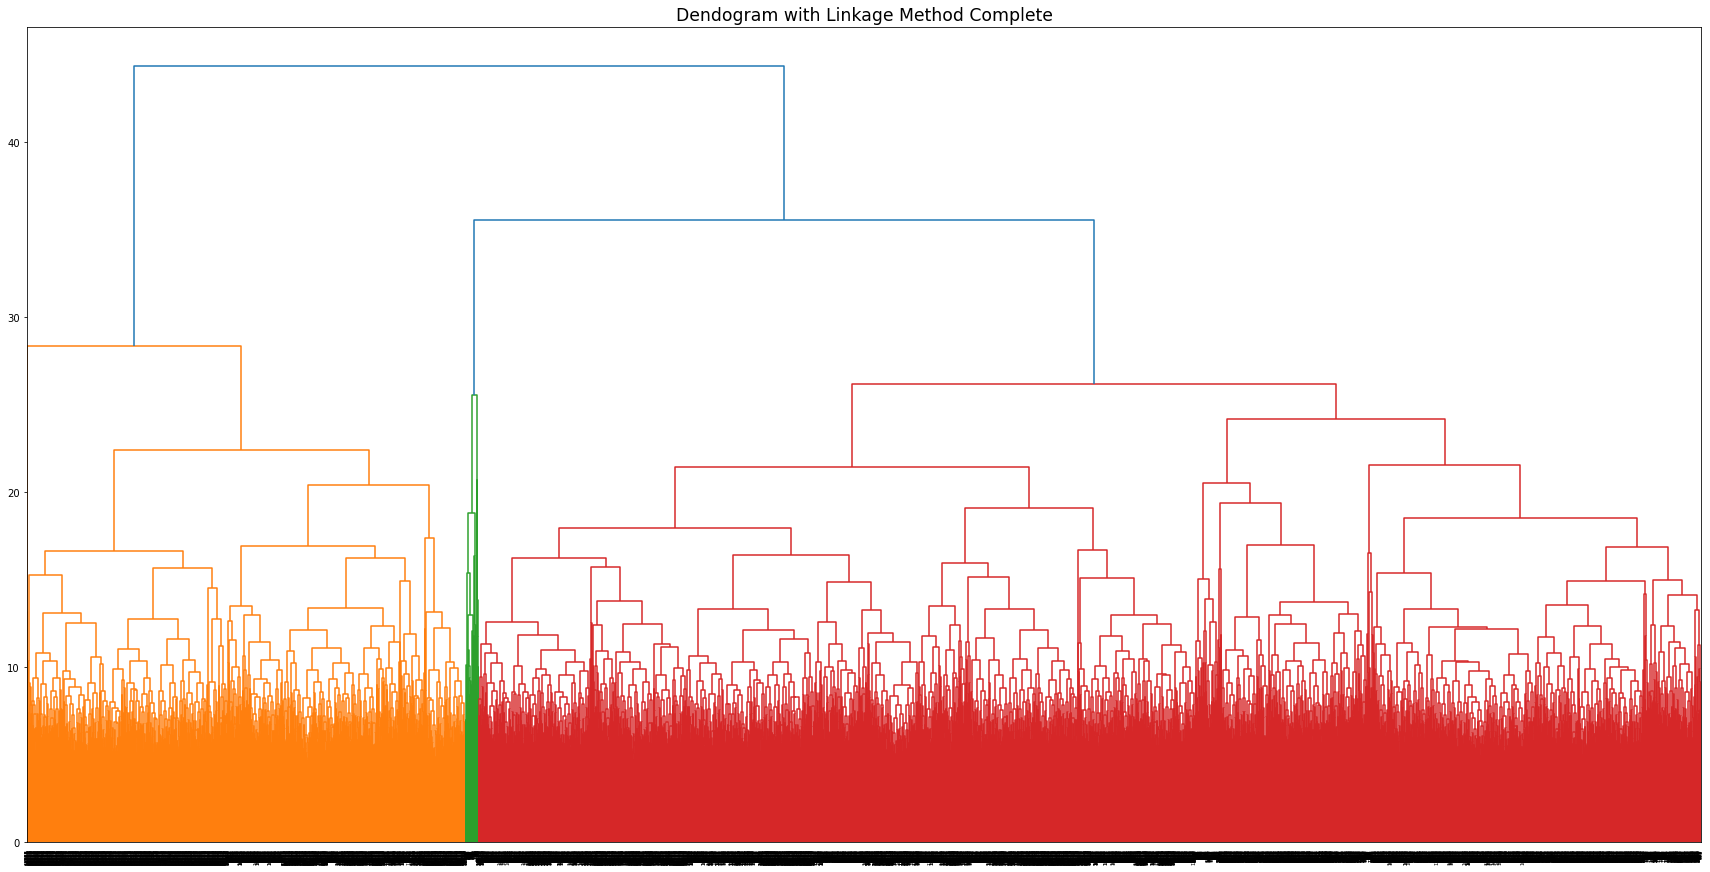

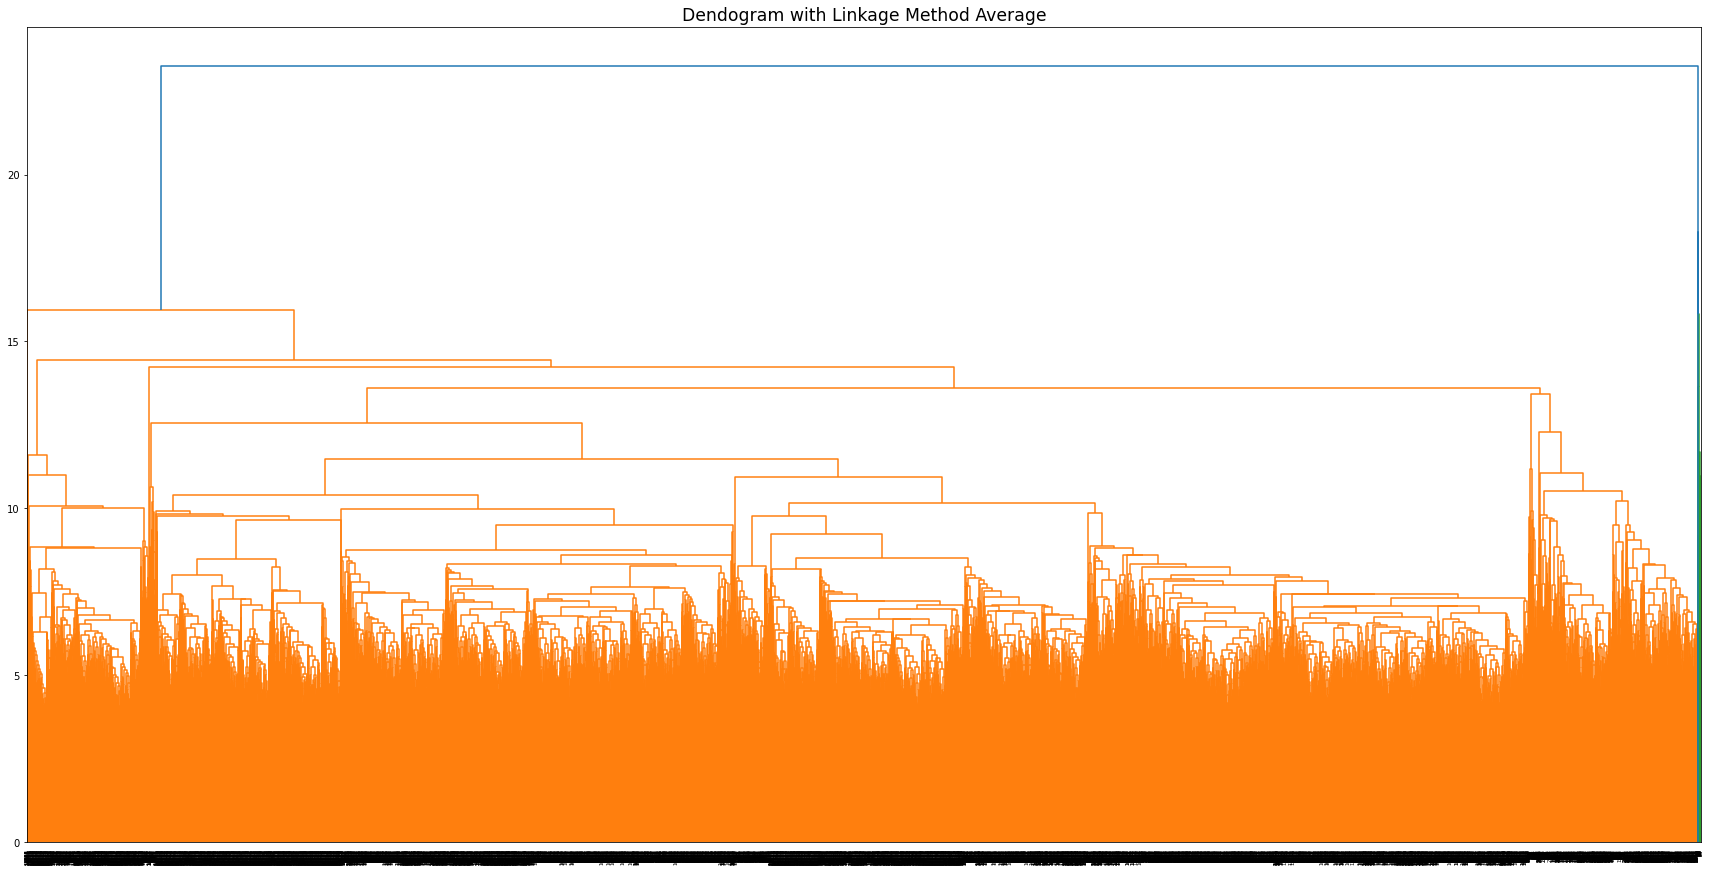

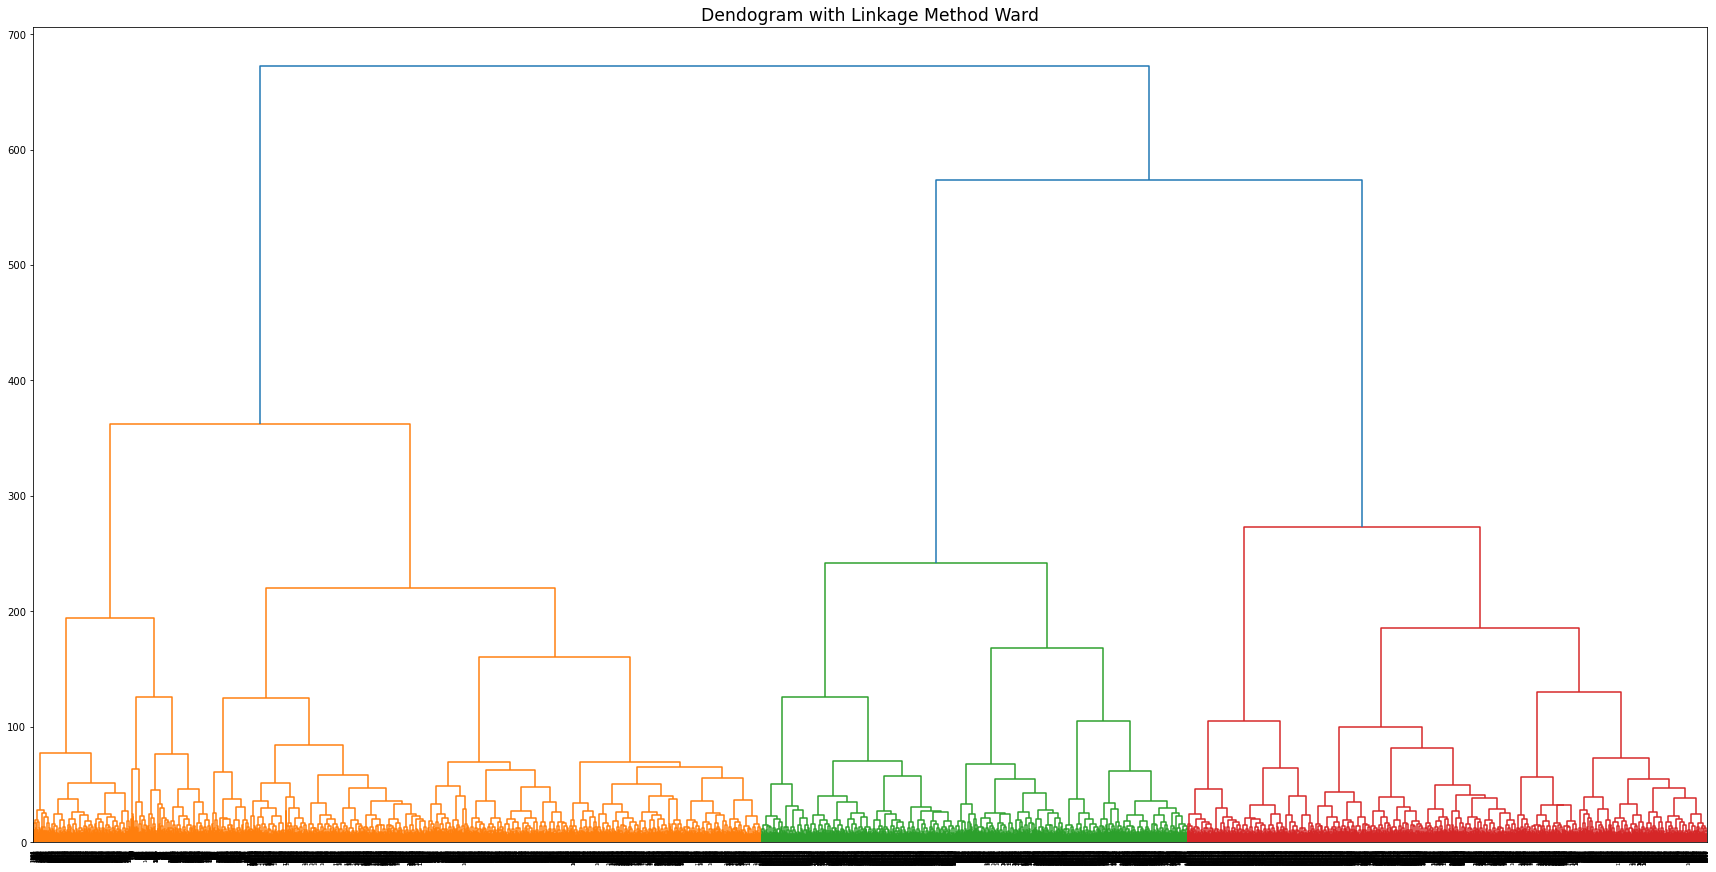

In [22]:
for method in linkages:
    plt.figure(figsize=(30,15))
    plt.title('Dendogram with Linkage Method {}'.format(method.capitalize())
              , size='xx-large')
    dendrogram(linkage(X, method=method))
    plt.show()

## DBSCAN
Assumptions and Considerations
- no need to supply a number of clusters
- one of the fastest methods
- true clusters must be linearly separable 

In [ ]:
# Defining the algorithm
dbscan_cluster = DBSCAN(eps=4, min_samples=100)

# Fit model
clusters = dbscan_cluster.fit_predict(X)

## GMM
- distributions must be gaussian
- soft clustering algorithm
- must supply K

In [ ]:
plot_hist_boxplot(df)

## Dimensionality Reduction

In [ ]:
import time

In [ ]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=1,
                      metric='mahalanobis').fit_transform(X)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
colors = ['red', 'black']
for i in range(umap_results.shape[0]):
    plt.scatter(umap_results[i, 0], umap_results[i, 1],
             #color=colors[int(y[i])],
             #fontdict={'weight': 'bold', 'size': 50}
        )

In [ ]:
dist

In [ ]:
dists = np.arange(.1, 1, .1)

for dist in dists:
    umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=dist,
                      metric='cosine').fit_transform(X)
    plt.scatter(umap_results[:, 0], umap_results[:, 1])
    plt.show()
    

In [ ]:
pca = PCA(n_components=2).fit_transform(X)

In [ ]:
plt.scatter(pca[:, 0], pca[:, 1])

In [ ]:
bbbb

In [ ]:
randomMatrix = np.random.uniform(-10,10,size=(20,3))
linked = linkage(randomMatrix, 'ward')

labels = ["A", "B", "C", "D"]
p = len(labels)

plt.figure(figsize=(8,4))
plt.title('Hierarchical Clustering Dendrogram (truncated)', fontsize=20)
plt.xlabel('Look at my fancy labels!', fontsize=16)
plt.ylabel('distance', fontsize=16)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])

# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{} - custom label!".format(temp[xx])

## This version gives you your label AND the count
# temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
# def llf(xx):
#     return "{} - {}".format(*temp[xx])


dendrogram(
            linked,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
plt.show()

In [ ]:
scaler = StandardScaler()

In [ ]:
X = scaler.fit_transform(fielders)

In [ ]:
X = pt.fit_transform(X)

In [ ]:
plot_hist_boxplot(X)

In [ ]:
X.shape

In [ ]:
for i in range(X.shape[1]):
    plt.figure(figsize=(8,4)) 
    plt.subplot(121)
    plt.hist(X[:, i])
    plt.show()
    
    plt.subplot(122)
    plt.boxplot(X[:, i])
    plt.show()
    

In [ ]:
from scipy.stats import boxcox

In [ ]:
boxcox(fielders['value'])

In [ ]:
std = scaler.fit_transform(fielders['wage'].values.reshape(-1,1))

In [ ]:
plt.hist(np.log(std[:, 0]))

In [ ]:
tmp = np.log(fielders['wage'])

In [ ]:
plt.hist(scaler.fit_transform(tmp.values.reshape(-1,1)))

In [ ]:
plt.hist(tmp)

In [ ]:
plt.hist(pt.fit_transform(scaler.fit_transform((fielders['value']).values.reshape(-1,1))))

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
fielders['wage'].hist(ax=ax)
fielders['value'].hist(alpha=.2, ax=ax)

In [ ]:
std.shape

In [ ]:
plt.hist(boxcox(std[:, 0] +1))

In [ ]:
fielders.drop([''])